In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import pynumdiff
import scipy.fftpack
from IPython.display import display,SVG
import figurefirst
fifi = figurefirst

/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
r = pynumdiff.utils.simulate.pi_control(timeseries_length=100, noise_parameters=[0, 0.1], dt=0.1, simdt=0.01)

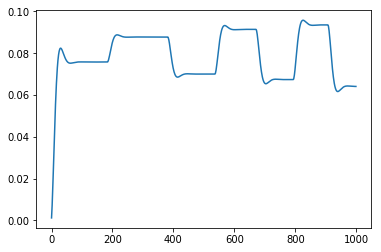

In [3]:
plt.plot(r[2])

In [4]:
import run_pareto_plot

In [5]:
def get_gamma(dt, freq, timeseries_length=None):
    try:
        if dt == 0.1:
            log_g = np.log(freq)*(-1.5) -4
        if dt == 0.01:
            log_g = np.log(freq)*(-1.5) -1.8
        if dt == 0.001:
            log_g = np.log(freq)*(-1.5) -1.2
            
        return np.exp(log_g)
    
    except:
        log_gs = []
        for f in freq:
            if dt == 0.1:
                log_gs.append(np.log(freq)*(-1.5) -4) 
            if dt == 0.01:
                log_gs.append(np.log(freq)*(-1.5) -1.8) 
            if dt == 0.001:
                log_gs.append(np.log(freq)*(-1.5) -1.2) 
            
        return np.exp(np.array(log_gs))
            


In [6]:
def plot_power_spectra(x, t, cutoff_freq=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.set_yscale('log')
    ax.set_xscale('log')
        
    yf = scipy.fftpack.fft(x)
    N = len(t)
    dt = np.mean(np.diff(t))
    xf = np.linspace(0.0, 1.0/(2.0*dt), N/2)
    
    P = 2.0/N * np.abs(yf[:N//2])
    ax.plot(xf, P, color='black', zorder=-10)
    
    if cutoff_freq is not None:
        ax.vlines(cutoff_freq, 1e-3, 1e1, color='red')

In [7]:
def make_plot(method, method_parent, problem, dt, noise, timeseries_length, cutoff_freq, 
              ax_data=None, ax_pos=None, ax_vel=None, ax_spectra=None):
    
    if ax_pos is None or ax_vel is None:
        fig = plt.figure()
        ax_data = fig.add_subplot(141)
        ax_pos = fig.add_subplot(142)
        ax_vel = fig.add_subplot(143)
        ax_spectra = fig.add_subplot(144)
        
    # simulate
    print('simulating')
    if problem == 'pi_control':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, simdt=0.01)
    elif problem != 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt)
    elif problem == 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, frequencies=[7, 10])
        
    x, x_truth, dxdt_truth, _ = r
    t = np.linspace(0, timeseries_length, len(x))
    print('done simulating')
    
    # optimize params
    tvgamma = get_gamma(dt, cutoff_freq)
    if method == 'jerk':
        if dt < 0.005:
            tvgamma = tvgamma * 100
    print('tvgamma: ', tvgamma)
    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=tvgamma)
    print('optimizer params: ', params)
    
    # estimate derivative
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
    
    # plot data
    #ax_data.plot(t, x, color='blue', zorder=1)
    ax_data.plot(t, x, '.', color='blue', zorder=-10, markersize=2)
    ax_data.set_rasterization_zorder(0)
    
    # plot vel
    ax_vel.plot(t, xdot_smooth, color='red')
    ax_vel.plot(t, dxdt_truth, '--', color='black')

    # plot pos
    ax_pos.plot(t, x_smooth, color='red')
    ax_pos.plot(t, x_truth, '--', color='black')
        
        
    ax_pos.set_xlim(0, timeseries_length)
    ax_vel.set_xlim(0, timeseries_length)
    ax_data.set_xlim(0, timeseries_length)
        
    plot_power_spectra(x, t, cutoff_freq, ax_spectra)
    

In [8]:
def load_data(fname):
    f = open(fname, 'rb')
    data = pickle.load(f)
    f.close()
    return data

In [9]:
def plot_rmse_errcorr(data, ax=None, plot=True):
    if ax is None:
        if plot:
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(111)
        
    keys = ['rmses', 'errcorrs', 'rmses_gamma', 'errcorrs_gamma']
    for key in keys:
        data[key][np.where(data[key]==None)] = np.nan
        data[key] = data[key].astype(float)
    
    print('n data pts: ', len(data['rmses']))
    #idx, opt_logrmse, opt_errcorr = find_elbow(np.log(data['rmses_gamma']), data['errcorrs_gamma'])
    #opt_gamma = data['metadata']['gammas'][idx]
    
    if plot:
        ax.plot((data['rmses']), data['errcorrs'], '.', color='gray', zorder=-10, markersize=2)
        ax.plot((data['rmses_gamma']), data['errcorrs_gamma'], '-', color='violet')
        ax.plot((data['rmses_gamma']), data['errcorrs_gamma'], '.', color='violet')
        #ax.plot(np.exp(opt_logrmse), opt_errcorr, '*', color='red', markersize=20)
        #ax.set_xlim(0, 5)
        ax.set_ylim(0, 1)
            
    #return opt_gamma

In [10]:
def plot_goldilocks_gamma(dt, cutoff_freq, x, x_truth, dxdt_truth, ax):
    tvgamma = get_gamma(dt, cutoff_freq)

    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=tvgamma)
    print(params)

    rmse, errcorr = run_pareto_plot.get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
    
    print('goldilocks rmse and errcorr: ', rmse, errcorr)
    ax.plot(rmse, errcorr, '*', color='red', markersize=20, markeredgecolor='black')
    
    #ax.set_xlim(1e-1, 1e2)

In [11]:
def prep_spines(layout, example, xlimits, ylimits, xticks, yticks):
    for ax_label, xlim in xlimits.items():
        ax = layout.axes[(example, ax_label)]
        ylim = ylimits[ax_label]
        ax.set_xlim(xlim[0], xlim[-1])
        ax.set_ylim(ylim[0], ylim[-1])
        
        if ax_label == 'spectra':
            ax.set_yscale('log')
            ax.set_xscale('log')
            print(xticks[ax_label])
            print(yticks[ax_label])
            ax.minorticks_off()
        if ax_label == 'pareto':
            ax.set_xscale('log')
            ax.minorticks_off()
        
        ax.set_xlim(xlim[0], xlim[-1])
        ax.set_ylim(ylim[0], ylim[-1])
        
        if 1:
            fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                             xticks=xticks[ax_label], 
                                             yticks=yticks[ax_label],
                                             tick_length=2.5,
                                             spine_locations={'left': 4, 'bottom': 4})

        ax.set_xlim(xlim[0], xlim[-1])
        ax.set_ylim(ylim[0], ylim[-1])
        
        if 1:
            fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                             xticks=xticks[ax_label], 
                                             yticks=yticks[ax_label],
                                             tick_length=2.5,
                                             spine_locations={'left': 4, 'bottom': 4})
            
        if ax_label == 'spectra' and example == 'example_1':
            xtl = ['$10^{' + str(int(np.log10(xticks['spectra'][0]))) + '}$',
                   '',
                   '',
                   '',
                   '$10^{' + str(int(np.log10(xticks['spectra'][-1]))) + '}$']
            ax.set_xticklabels(xtl)
            
            ytl = ['$10^{' + str(int(np.log10(yticks['spectra'][0]))) + '}$',
                   '',
                   '',
                   '',
                   '$10^{' + str(int(np.log10(yticks['spectra'][-1]))) + '}$']
            ax.set_yticklabels(ytl)
            
        elif ax_label == 'spectra':
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        
    fifi.mpl_functions.set_fontsize(ax, 6)

In [12]:
def go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
       xlimits, ylimits, xticks, yticks, read_existing=True):
    # simulate
    print('simulating')
    if problem == 'pi_control':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, simdt=0.01)
        simdt = 0.01
    elif problem != 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt)
        simdt = 0.0001
    elif problem == 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, frequencies=[7, 10])
        simdt = 0.0001
        
    x, x_truth, dxdt_truth, _ = r
    print('done simulating')
    
    # run_pareto_analysis
    if problem == 'sine':
        fname = run_pareto_plot.run_pareto_analysis_on_specific(noise, dt, timeseries_length, problem, method, method_parent, simdt=simdt, frequencies=[7,10], read_existing=read_existing)
    else:
        fname = run_pareto_plot.run_pareto_analysis_on_specific(noise, dt, timeseries_length, problem, method, method_parent, simdt=simdt, read_existing=read_existing)
    
    # get axes
    print('EXAMPLE: ', example)
    layout = fifi.svg_to_axes.FigureLayout(figure_layout, autogenlayers=True, 
                                           make_mplfigures=True, hide_layers=[])
    ax_data = layout.axes[(example, 'data')]
    ax_pos = layout.axes[(example, 'pos')]
    ax_vel = layout.axes[(example, 'vel')]
    ax_spectra = layout.axes[(example, 'spectra')]
    ax_pareto = layout.axes[(example, 'pareto')]

    # make pos, vel, spectra plots
    make_plot(method, method_parent, problem, dt, noise, timeseries_length, cutoff_freq, 
                  ax_data=ax_data, ax_pos=ax_pos, ax_vel=ax_vel, ax_spectra=ax_spectra)

    # make pareto plot
    data = load_data(fname)
    ax_pareto.set_xscale("log")
    plot_rmse_errcorr(data, ax=ax_pareto, plot=True)
    ax_pareto.set_rasterization_zorder(0)
    plot_goldilocks_gamma(dt, cutoff_freq, x, x_truth, dxdt_truth, ax_pareto)
    
    
    # prep spines
    prep_spines(layout, example, xlimits, ylimits, xticks, yticks)
    
    
    # save
    layout.append_figure_to_layer(layout.figures[example], example, cleartarget=True)
    layout.write_svg(figure_layout)

In [13]:
figure_layout = 'fig_3_kalman.svg'

In [14]:
read_existing = True

In [15]:
# define method
method_parent = 'kalman_smooth'
method = 'constant_acceleration'

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.1_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.1_0.01_4_auto.pickle
EXAMPLE:  example_1
simulating
done simulating
tvgamma:  0.05844198239204049
optimizer params:  [0.07625000000000004, 12375.0]
n data pts:  5625
[0.07625000000000004, 12375.0]
goldilocks rmse and errcorr:  0.8867866333826331 0.05371705411362382
[0.01, 0.1, 1.0, 10.0, 100.0]
[0.001, 0.01, 0.1, 1.0, 10.0]


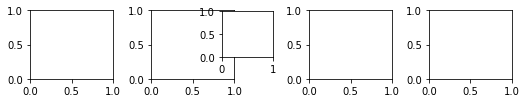

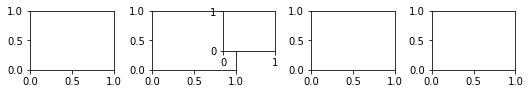

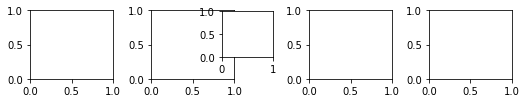

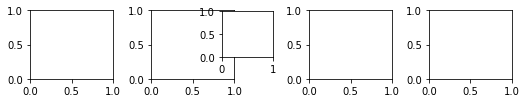

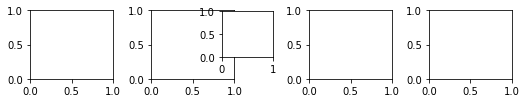

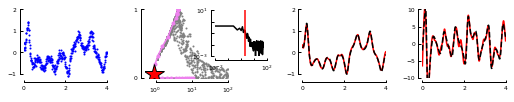

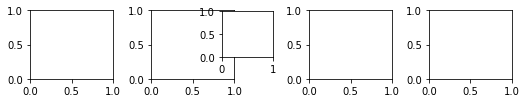

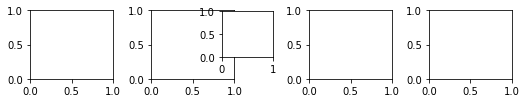

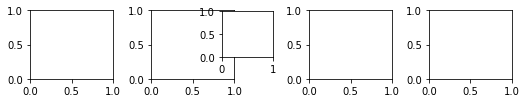

In [16]:
# define problem
example = 'example_1'
dt = 0.01
noise = 0.1
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'

# define limits
xlimits = {'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {'data': [-1.2,2],
           'pos': [-1.2,2],
           'vel': [-10, 10],
           'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {'data': [-1, 0, 1, 2],
           'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}



go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.1_0.1_4_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.1_0.1_4_auto.pickle
EXAMPLE:  example_2
simulating
done simulating
tvgamma:  0.0064755562299939895
optimizer params:  [1.815624999999998e-08, 0.0037500000000001144]
n data pts:  5625
[1.815624999999998e-08, 0.0037500000000001144]
goldilocks rmse and errcorr:  2.7041329133751226 0.3735335434190746
[0.01, 0.1, 1.0, 10.0, 100.0]
[0.001, 0.01, 0.1, 1.0, 10.0]


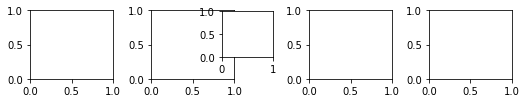

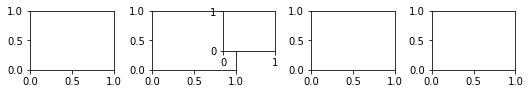

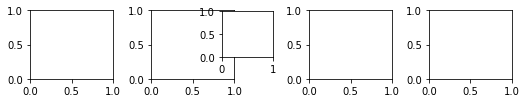

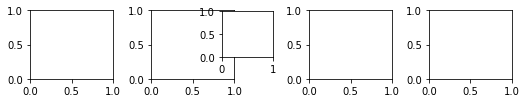

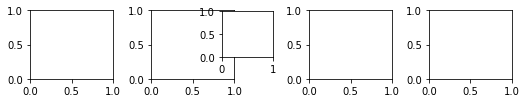

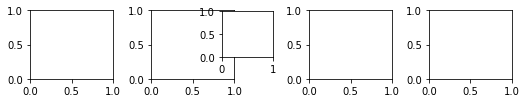

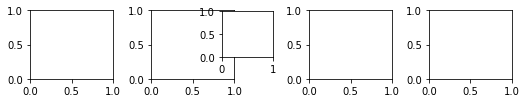

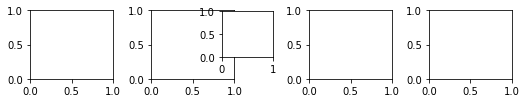

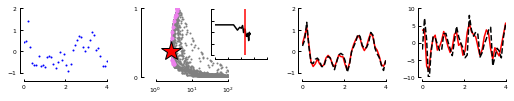

In [17]:
# define problem
example = 'example_2'
dt = 0.1
noise = 0.1
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'

# define limits
xlimits = {'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {'data': [-1.2,2],
           'pos': [-1.2,2],
           'vel': [-10, 10],
           'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {'data': [-1, 0, 1, 2],
           'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.5_0.01_4_auto.pickle
EXAMPLE:  example_3
simulating
done simulating
tvgamma:  0.05844198239204049
optimizer params:  [0.0001678124999999998, 1.875]
n data pts:  5625
[0.0001678124999999998, 1.875]
goldilocks rmse and errcorr:  1.8636200332579653 0.1847723339873928
[0.01, 0.1, 1.0, 10.0, 100.0]
[0.001, 0.01, 0.1, 1.0, 10.0]


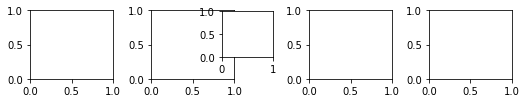

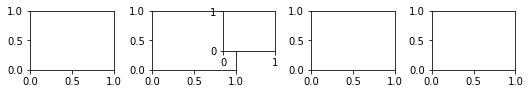

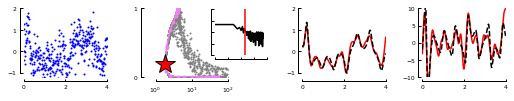

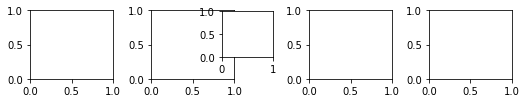

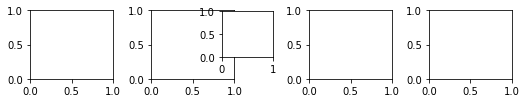

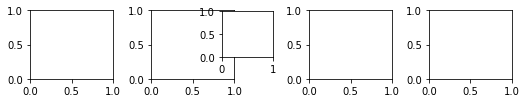

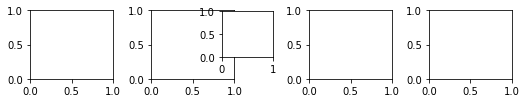

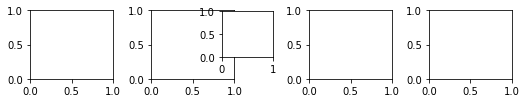

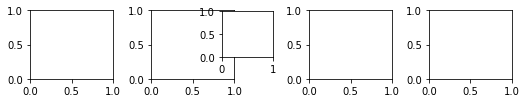

In [18]:
# define problem
example = 'example_3'
dt = 0.01
noise = 0.5
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'

# define limits
xlimits = {'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {'data': [-1.2,2],
           'pos': [-1.2,2],
           'vel': [-10, 10],
           'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {'data': [-1, 0, 1, 2],
           'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.5_0.1_4_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.5_0.1_4_auto.pickle
EXAMPLE:  example_4
simulating
done simulating
tvgamma:  0.0064755562299939895
optimizer params:  [1.875000000000015e-09, 0.0001678124999999998]
n data pts:  5625
[1.875000000000015e-09, 0.0001678124999999998]
goldilocks rmse and errcorr:  4.301095390517382 0.32969843445580677
[0.01, 0.1, 1.0, 10.0, 100.0]
[0.001, 0.01, 0.1, 1.0, 10.0]


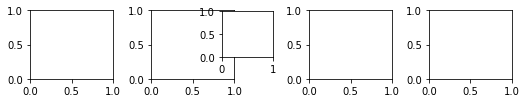

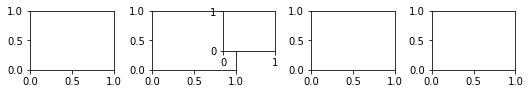

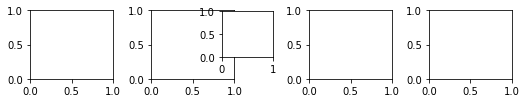

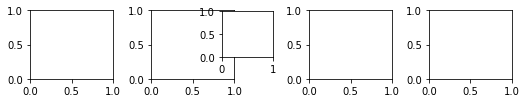

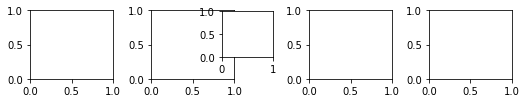

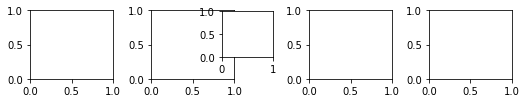

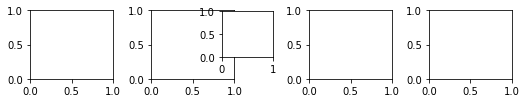

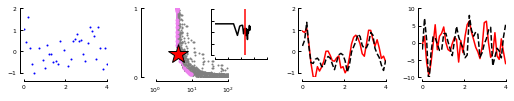

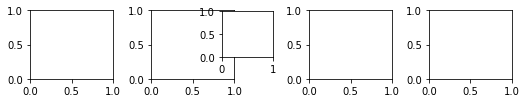

In [19]:
# define problem
example = 'example_4'
dt = 0.1
noise = 0.5
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'

# define limits
xlimits = {'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {'data': [-1.2,2],
           'pos': [-1.2,2],
           'vel': [-10, 10],
           'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {'data': [-1, 0, 1, 2],
           'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_pop_dyn_0.1_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_pop_dyn_0.1_0.01_4_auto.pickle
EXAMPLE:  example_5
simulating
done simulating
tvgamma:  0.12574712473539992
optimizer params:  [13.5390625, 6093.75]
n data pts:  5625
[13.5390625, 6093.75]
goldilocks rmse and errcorr:  0.16092637551033287 0.013770627105273778
[0.01, 0.1, 1.0, 10.0, 100.0]
[0.001, 0.01, 0.1, 1.0, 10.0]


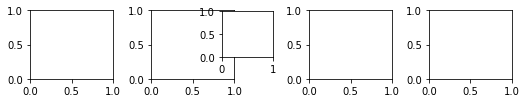

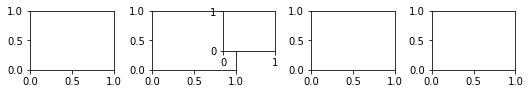

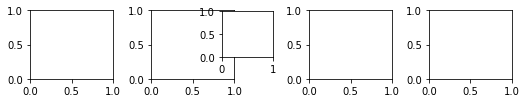

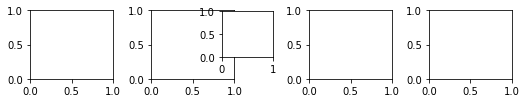

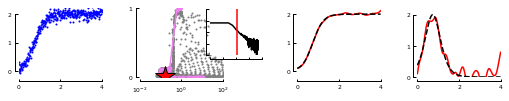

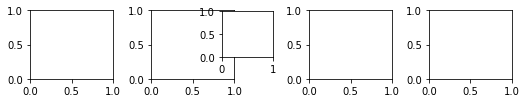

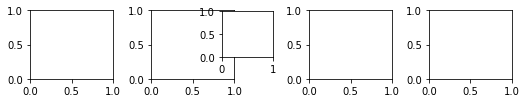

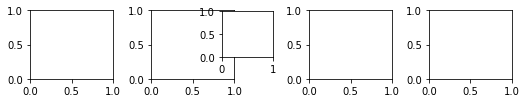

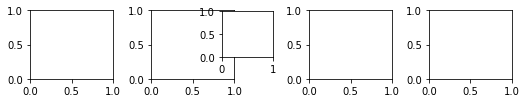

In [20]:
# define problem
example = 'example_5'
dt = 0.01
noise = 0.1
timeseries_length = 4
cutoff_freq = 1.2
problem = 'pop_dyn'

# define limits
xlimits = {'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           'spectra': [1e-2,1e2],
           'pareto': [1e-2, 1e2]}
ylimits = {'data': [-0.2,2.2],
           'pos': [-0.2,2.2],
           'vel': [0, 2.2],
           'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e-2, 1e0, 1e2]}
yticks = {'data': [0, 1, 2],
           'pos': [0, 1, 2],
           'vel': [0,1,2],
           'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_triangle_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_triangle_0.5_0.01_4_auto.pickle
EXAMPLE:  example_6
simulating
done simulating
tvgamma:  0.08997731804271983
optimizer params:  [4.125, 15718.75]
n data pts:  5625
[4.125, 15718.75]
goldilocks rmse and errcorr:  1.6099923533663811 0.05388718146093738
[0.01, 0.1, 1.0, 10.0, 100.0]
[0.001, 0.01, 0.1, 1.0, 10.0]


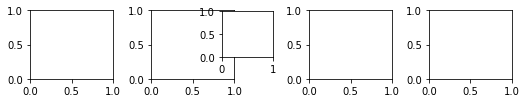

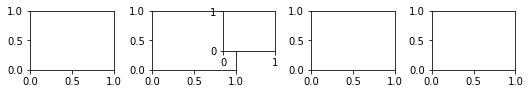

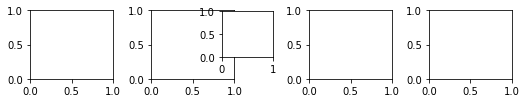

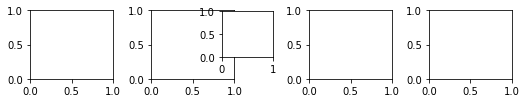

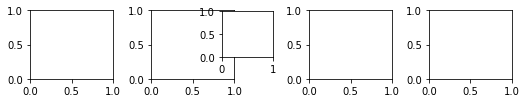

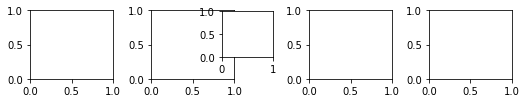

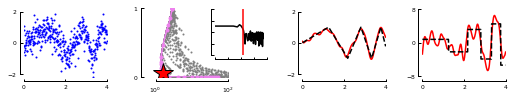

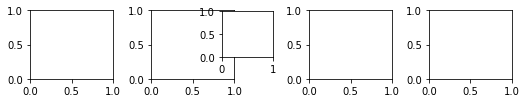

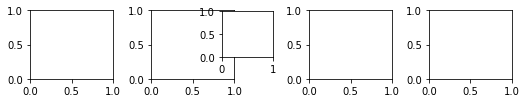

In [21]:
# define problem
example = 'example_6'
dt = 0.01
noise = 0.5
timeseries_length = 4
cutoff_freq = 1.5
problem = 'triangle'

# define limits
xlimits = {'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {'data': [-2.2,2.2],
           'pos': [-2.2,2.2],
           'vel': [-8.2, 8.2],
           'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e2]}
yticks = {'data': [-2, 0, 2],
           'pos': [-2, 0, 2],
           'vel': [-8,0,8],
           'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_sine_0.5_0.001_1_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_sine_0.5_0.001_1_auto.pickle
EXAMPLE:  example_7
simulating
done simulating
tvgamma:  0.009524597277019774
optimizer params:  [1.815624999999998e-08, 0.375]
n data pts:  5625
[1.815624999999998e-08, 0.375]
goldilocks rmse and errcorr:  11.428471125557863 0.0016809826119535676
[0.01, 0.1, 1.0, 10.0, 100.0]
[0.001, 0.01, 0.1, 1.0, 10.0]


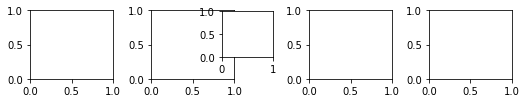

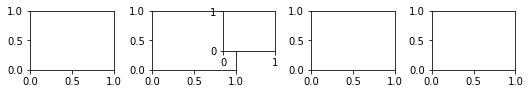

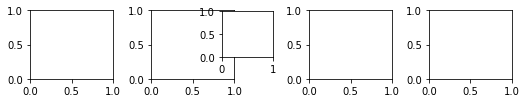

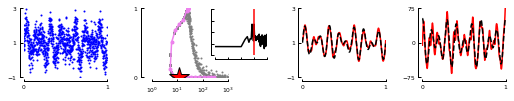

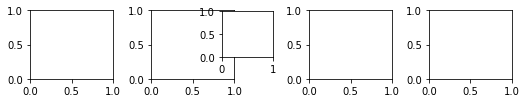

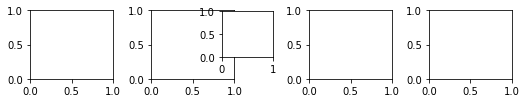

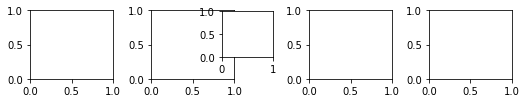

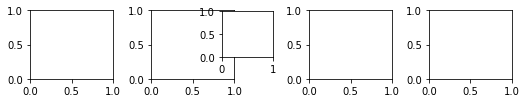

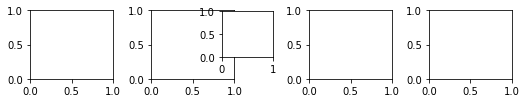

In [22]:
# define problem
example = 'example_7'
dt = 0.001
noise = 0.5
timeseries_length = 1
cutoff_freq = 10
problem = 'sine'

xlimits = {'data': [0,1],
           'pos': [0,1],
           'vel': [0,1],
           'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e3]}
ylimits = {'data': [-1,3],
           'pos': [-1,3],
           'vel': [-75, 75],
           'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {'data': [0,1],
           'pos': [0,1],
           'vel': [0,1],
           'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2, 1e3]}
yticks = {'data': [-1, 1, 3],
           'pos': [-1, 1, 3],
           'vel': [-75,0,75],
           'spectra': [1e-3, 1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_pi_control_0.05_0.1_100_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_pi_control_0.05_0.1_100_auto.pickle
EXAMPLE:  example_8
simulating
done simulating
tvgamma:  1.6382005442619334
optimizer params:  [0.013750000000000095, 0.00017906249999999978]
n data pts:  5625
[0.013750000000000095, 0.00017906249999999978]
goldilocks rmse and errcorr:  0.00536171648878231 0.009930489600395435
[0.01, 0.1, 1.0, 10.0, 100.0]
[0.001, 0.01, 0.1, 1.0, 10.0]


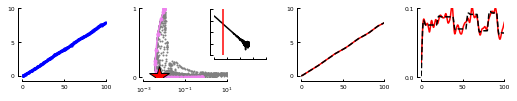

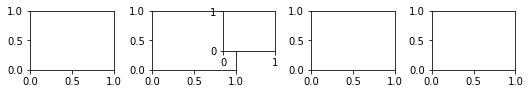

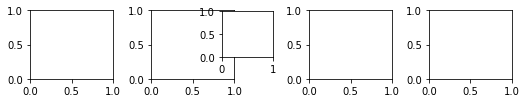

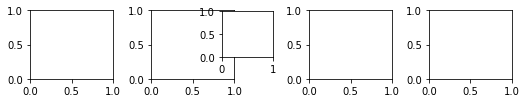

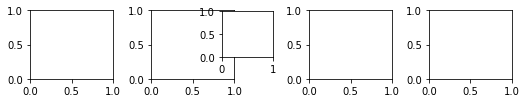

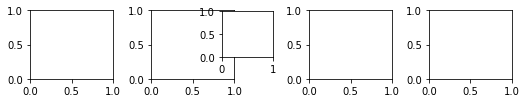

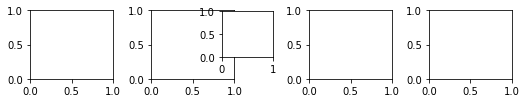

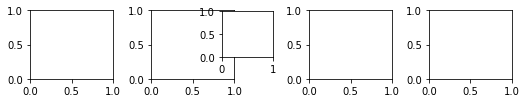

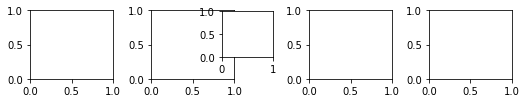

In [23]:
# define problem
example = 'example_8'
dt = 0.1
noise = 0.05
timeseries_length = 100
cutoff_freq = 0.05
problem = 'pi_control'

xlimits = {'data': [0,100],
           'pos': [0,100],
           'vel': [0,100],
           'spectra': [1e-2,1e2],
           'pareto': [1e-3, 1e1]}
ylimits = {'data': [-0.2,10],
           'pos': [-0.2,10],
           'vel': [0, 0.1],
           'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {'data': [0,50,100],
           'pos': [0,50,100],
           'vel': [0,50,100],
           'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e-3, 1e-1, 1e1]}
yticks = {'data': [0, 5, 10],
           'pos': [0, 5, 10],
           'vel': [0,0.1],
           'spectra': [1e-3, 1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)